# Final Project (30%)

For the final project, you will need to implement a "new" statistical algorithm in Python from the research literature and write a "paper" describing the algorithm. 

Deadline 2nd May 2018 at 11:59 PM

Note: 1 bonus point for each day that it is submitted before the deadline. The actual project has a maximum grade of 100, but bonus points can push it above 100.

## Paper

The paper should have the following:

### Title

Should be consise and informative.

### Abstract

250 words or less. Identify 4-6 key phrases.

### Background

State the research paper you are using. Describe the concept of the algorithm and why it is interesting and/or useful. If appropriate, describe the mathematical basis of the algorithm. Some potential topics for the backgorund include:

- What problem does it address? 
- What are known and possible applications of the algorithm? 
- What are its advantages and disadvantages relative to other algorithms?
- How will you use it in your research?

### Description of algorithm

First, explain in plain English what the algorithm does. Then describes the details of the algorihtm, using mathematical equations or pseudocode as appropriate. 

### Describe optimization for performance

First implement the algorithm using plain Python in a straightforward way from the description of the algorihtm. Then profile and optimize it using one or more apporpiate mathods, such as:

1. Use of better algorithms or data structures
2. Use of vectorization
3. JIT or AOT compilation of critical functions
4. Re-writing critical functions in C++ and using pybind11 to wrap them
5. Making use of parallelism or concurrency
6. Making use of distributed compuitng

Document the improvemnt in performance with the optimizations performed.

### Applications to simulated data sets

Are there specific inputs that give known outuputs (e.g. there might be closed form solutions for special input cases)? How does the algorithm perform on these? 

If no such input cases are available (or in addition to such input cases), how does the algorithm perform on simulated data sets for which you know the "truth"? 

### Applications to real data sets

Test the algorithm on the real-world examples in the orignal paper if possible. Try to find at least one other real-world data set not in the original paper and test it on that. Describe and interpret the results.

### Comparative analysis with competing algorihtms

Find two other algorihtms that addresss a similar problem. Perform a comparison - for example, of accurary or speed. You can use native libraires of the other algorithms - you do not need to code them yourself. Comment on your observations. 

### Discussion/conclusion

Your thoughts on the algorithm. Does it fulfill a particular need? How could it be generalized to other problem domains? What are its limiations and how could it be improved further?

### References/bibliography

Make sure you cite your sources.

## Code

The code should be in a public GitHub repository with:

1. A README file
2. An open source license
3. Source code
4. Test code
5. Examples
6. A reproducible report

The package should be downloadable and installable with `python setup.py install`, or even posted to PyPI adn installable with `pip install package`.


## Rubric

Each item is worth 10 points, but some sections will give up to 10 bonus points if done really well. Note that the "difficulty factor" of the chosen algorithm will be factored into the grading. 

1. Is the abstract, background and discussion readable and clear? (10-20 points)
2. Is the algorithm description clear and accurate? (10-20 points)
3. Has the algorihtm been optimized? (10-20 points)
4. Are the applicaitons to simulated/real data clear and useful? (10-20 points)
5. Was the comarative analysis done well? (10-20 points points)
6. Is there a well-maitnatined Github repository for the code? (10 points)
7. Is the document show evidenc of literate programming? (10 points)
8. Is the analyiss reproducible? (10 points)
9. Is the code tested? Are examples provided? (10 points)
10. Is the package easily installable? (10 points)



In [23]:
import numpy as np
import pandas as pd
import scipy.stats
import scipy.linalg
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numba
from numba import jit
import seaborn as sns

# The Code

### Code for U, Gradient, H functions

In [24]:
def U(X, y, theta, theta_p, sig, sig_p):
    """Compute likelihood function U with vector"""
    return - sum(np.log(scipy.stats.norm.pdf(y, X @ theta, sig))
                 -np.log(scipy.stats.multivariate_normal.pdf(theta, mean = theta_p, cov = sig_p)))

def grad_U(X, y, theta, theta_p, sig, sig_p_inv):
    return -(y - X @ theta).T @ np.eye(X.shape[0]) / (sig**2) @ X + ((theta-theta_p).reshape(-1, 1).T@sig_p_inv).flatten()

def H(X, y, theta, sig, r ,U, M_inv, theta_p, sig_p_inv):
    '''Hamiltonian function of total energy'''
    return U(X, y, theta, theta_p, sig, sig_p_inv) + 0.5 * r.T @ M_inv @ r

### Hamiltonian Monte Carlo

In [33]:
def hmc(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p):
    """Hamiltonian Monte Carlo"""
    d = theta_0.shape[0]
    Theta = np.empty((d, niter))
    R = np.empty((d, niter))
    M_inv = scipy.linalg.inv(M)
    sig_p_inv = scipy.linalg.inv(sig_p)
    theta = theta_0.copy()
    a = 0
    for i in range(niter):
        r = np.random.multivariate_normal(np.zeros(d), M, 1).flatten()
        theta_old = theta.copy()
        r_old = r.copy()          
        #discretize Hamiltonian dynamics
        r -= eps / 2 * grad_U(X, y, theta, theta_p, sig, sig_p_inv)
        for j in range(m):
            theta += eps * M_inv @ r
            r -= eps * grad_U(X, y, theta, theta_p, sig, sig_p_inv)
        r -= eps / 2 * grad_U(X, y, theta, theta_p, sig, sig_p_inv)
        #M-H correction
        u = np.random.uniform(0, 1, 1)
        rho = np.exp(H(X, y, theta, sig, r ,U, M_inv, theta_p, sig_p_inv) -
                     H(X, y, theta_old, sig, r_old ,U, M_inv, theta_p, sig_p_inv))
        if u < rho:
            Theta[:,i] = theta
            R[:,i] = r
            a += 1
        else:
            Theta[:,i] = theta_old
            R[:,i] = r_old
        theta = Theta[:,i]        
    return Theta, R, a

### Stochastic gradient HMC

In [20]:
def sghmc(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p, perc, C, B_hat):
    """Stochastic Gradient Hamiltonian Monte Carlo"""
    # theta_0: the starting point
    # eps: step length in solving the dynamic system
    # niter: the number sampling
    # m: the maximum number of steps to take for solving the Hamiltonian
    # M: the mass matrix in the Hamiltonian
    # perc: the percentage of minbatch size over total size
    d = theta_0.shape[0]
    batch_size = int(np.floor(X.shape[0] * perc))
    Theta = np.empty((d, niter))
    R = np.empty((d, niter))
    M_inv_eps = scipy.linalg.inv(M) * eps
    sig_p_inv = scipy.linalg.inv(sig_p)
    theta = theta_0.copy()
    M0 = C @ M_inv_eps
    V = 2*eps*(C - B_hat)
    for i in range(niter):
        r = np.random.multivariate_normal(np.zeros(d), M, 1).flatten()      
        for j in range(m):
            theta += M_inv_eps @ r.flatten()           
            idx = np.random.randint(batch_size, size = (batch_size,))
            X0 = X[idx, ] #sample X
            y0 = y[idx]
            r = r - eps * grad_U(X0, y0, theta, theta_p, sig, sig_p_inv) - M0 @ r + np.random.multivariate_normal(np.zeros(d), V, 1).flatten()        
        Theta[:,i] = theta
        R[:,i] = r
        
    return Theta, R

# Optimization

### Using numba

In [26]:
@jit
def hmc_numba(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p):
    """Hamiltonian Monte Carlo"""
    d = theta_0.shape[0]
    Theta = np.empty((d, niter))
    R = np.empty((d, niter))
    M_inv = scipy.linalg.inv(M)
    sig_p_inv = scipy.linalg.inv(sig_p)
    theta = theta_0.copy()
    a = 0
    for i in range(niter):
        r = np.random.multivariate_normal(np.zeros(d), M, 1).flatten()
        theta_old = theta.copy()
        r_old = r.copy()          
        #discretize Hamiltonian dynamics
        r -= eps / 2 * grad_U(X, y, theta, theta_p, sig, sig_p_inv)
        for j in range(m):
            theta += eps * M_inv @ r
            r -= eps * grad_U(X, y, theta, theta_p, sig, sig_p_inv)
        r -= eps / 2 * grad_U(X, y, theta, theta_p, sig, sig_p_inv)
        #M-H correction
        u = np.random.uniform(0, 1, 1)
        rho = np.exp(H(X, y, theta, sig, r ,U, M_inv, theta_p, sig_p_inv) -
                     H(X, y, theta_old, sig, r_old ,U, M_inv, theta_p, sig_p_inv))
        if u < rho:
            Theta[:,i] = theta
            R[:,i] = r
            a += 1
        else:
            Theta[:,i] = theta_old
            R[:,i] = r_old
        theta = Theta[:,i]        
    return Theta, R, a

# Application to Simulated Dataset

In [27]:
# data simulation
mu_1 = 0
sigma_1 = 1
mu_2 = 5
sigma_2 = 3
mu_3 = 7
sigma_3 = 3
n = 100
x_1 = np.random.normal(mu_1, sigma_1, n)
x_2 = np.random.normal(mu_2, sigma_2, n)
x_3 = np.random.normal(mu_3, sigma_3, n)
noise = np.random.normal(0, 5, n)
b1 = 5
b2 = 3
b3 = -2

y_sim = b1*x_1 + b2*x_2 + b3*x_3+noise
X_sim = np.array([x_1, x_2, x_3]).T

d = X_sim.shape[1]
theta_0_sim = np.array([3.0, 2.0, -1.0])
eps = 0.09
niter = 10000
M = np.eye(d)
m = 3
p_sim = 3
sig_sim = 5
sig_sim2 = sig_sim**2
sig_p_sim = np.diag([10.0, 10.0, 10.0])
theta_p_sim = np.array([0, 0, 0])
Theta_sim, R_sim, a_sim = hmc(X_sim, y_sim, theta_0_sim, eps, niter, m, M, U, grad_U, sig_sim, theta_p_sim, sig_p_sim)

In [28]:
## Analytic solution
sig_p_sim_inv = scipy.linalg.inv(sig_p_sim)
cov_sim_pos = scipy.linalg.inv(sig_p_sim_inv+X_sim.T@X_sim/sig_sim2)
mu_sim_pos = cov_sim_pos@(sig_p_sim_inv@theta_0_sim+X_sim.T@y_sim/sig_sim2)

In [29]:
d = X_sim.shape[1]
theta_0_sim = np.array([3.0, 2.0, -1.0])
eps = 0.09
niter = 10000
M = np.eye(d)
m = 3
p_sim = 3
sig_sim = 5
sig_sim2 = sig_sim**2
sig_p_sim = np.diag([10.0, 10.0, 10.0])
theta_p_sim = np.array([0, 0, 0])
perc = 0.3
B_hat = 0 # should be a matrix here
C = np.eye(d)
Theta_sghmc,_ = sghmc(X_sim, y_sim, theta_0_sim, eps, niter, m, M, U, grad_U, sig_sim, theta_p_sim, sig_p_sim, perc, C, B_hat)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


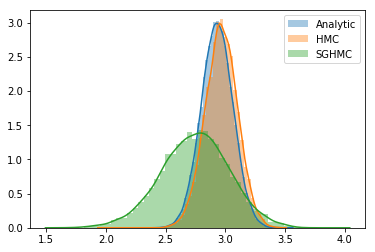

In [34]:
beta_sim_pos = np.random.multivariate_normal(mu_sim_pos, cov_sim_pos, 50000)
sns.distplot(beta_sim_pos[:,1], label="Analytic")
sns.distplot(Theta_sim[1, :], label="HMC")
sns.distplot(Theta_sghmc[1, :], label="SGHMC")
plt.legend(labels=['Analytic', 'HMC', 'SGHMC'])
plt.savefig("simulated_dist_plot")
pass

# Application to Diabetes Dataset

### Setup the dataset

In [37]:
# Load the diabetes dataset
d = datasets.load_diabetes()
data = pd.DataFrame(data= np.c_[d['data']],
                     columns= d['feature_names'])
data = data.iloc[:, 0:4]
data.iloc[0:3,:]

,age,sex,bmi,bp
0,0.038076,0.050680,0.061696,0.021872
1,-0.001882,-0.044642,-0.051474,-0.026328
2,0.085299,0.050680,0.044451,-0.005671


In [38]:
# Load the diabetes dataset
d = datasets.load_diabetes()
X = d['data'][:,0:4]
y = d['target']
n, p = X.shape

# Compute the OLS variance
reg = LinearRegression().fit(X, y)
y_hat = reg.predict(X)
sig2 = sum((y - y_hat)**2)/(n - p)
sig = np.sqrt(sig2)
sig2 = sum((y-y_hat)**2)/(n-p)
theta_p = reg.coef_
sig_p = np.eye(p)*500

### Test for HMC

In [56]:
# test for HMC
d = X.shape[1]
theta_0 = reg.coef_.copy()
eps = 0.01
niter = 10000
M = np.eye(d)
m = 3

In [57]:
Theta_hmc, R, a = hmc(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p)

In [106]:
%timeit hmc(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p)
%timeit hmc_numba(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p)

5.64 s ± 298 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.35 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Test for SG-HMC

In [58]:
eps = 1.5
niter = 10000
M = np.eye(d)
m = 7
perc = 0.5
B_hat = 0 # should be a matrix here
C = np.eye(d)*0.01

In [50]:
Theta_sghmc, R= sghmc(X, y, theta_0, eps, niter, m, M, U, grad_U, sig, theta_p, sig_p, perc, C, B_hat)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


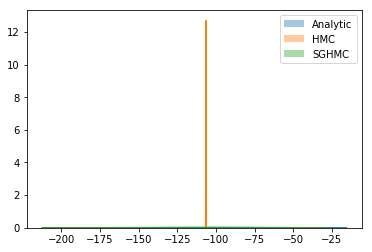

In [59]:
sig_p_hmc = scipy.linalg.inv(sig_p)
cov_pos_hmc = scipy.linalg.inv(sig_p_hmc+X.T@X/sig2)
mu_pos_hmc = cov_pos_hmc @ (sig_p_hmc@theta_0+X.T @ y/sig2)
beta_pos_hmc = np.random.multivariate_normal(mu_pos_hmc, cov_pos_hmc, 50000)
sns.distplot(beta_pos_hmc[:,1], label="Analytic")
sns.distplot(Theta_hmc[1, :], label="HMC")
sns.distplot(Theta_sghmc[1, :], label="SGHMC")
plt.legend(labels=['Analytic', 'HMC', 'SGHMC'])
plt.savefig("real_plot")
pass